<a href="https://colab.research.google.com/github/pachterlab/CP_2023/blob/main/notebooks/celltypePred_Fig4a/kimetal_smartseq_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#SMART-seq VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')

#smartseq.mtx (raw counts)
download_file('10.22002/D1.2070','.gz')

#gene names
download_file('10.22002/D1.2068','.gz')


os.system("gunzip *.gz")

os.system("mv D1.2067 metadata.csv")
os.system("mv D1.2071 smartseq.mtx")

os.system("mv D1.2070 smartseqCount.mtx")
os.system("mv D1.2068 gene_names.npy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

  0%|          | 0/16654 [00:00<?, ?B/s]

  0%|          | 0/11 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/pachterlab/CP_2023.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 470 (delta 19), reused 19 (delta 5), pack-reused 424
Receiving objects: 100% (470/470), 159.66 MiB | 16.87 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [ ]:
!pwd

/content


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy
!pip3 install --quiet scvi-tools

     |████████████████████████████████| 96 kB 4.1 MB/s 
     |████████████████████████████████| 7.7 MB 36.0 MB/s 
     |████████████████████████████████| 88 kB 8.3 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 56.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 296 kB 32.9 MB/s 
     |████████████████████████████████| 708 kB 57.0 MB/s 
     |████████████████████████████████| 722 kB 67.8 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 237 kB 66.1 MB/s 
     |████████████████████████████████| 529 kB 66.6 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 185 kB 72.9 MB/s 
     |████████████████████████████████| 292 kB 70.9 MB/s 
     |████████████████████████████████| 145 kB 68.6 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |██████████████████████

In [ ]:
%cd /content/CP_2023/scripts

/content/CP_2022/scripts


## **Install Packages**

In [ ]:
import anndata
import pandas as pd
import numpy as np
from MCML import MCML #Now has continuous label addition

import random
import scvi
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
sns.set_style('white')

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

pcs = 50
pcs2 = 40
n_latent = 50

In [ ]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [ ]:
raw_count_mat = sio.mmread(data_path+'/smartseqCount.mtx')
raw_count_mat.shape

(3850, 1999)

In [ ]:
#Center and scale data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


In [ ]:
clusters = np.unique(meta['smartseq_cluster'].values)
map_dict = {}
for i, c in enumerate(clusters):
  map_dict[c] = i
new_labs = [map_dict[c] for c in meta['smartseq_cluster'].values]

In [ ]:
adata = anndata.AnnData(count_mat, obs = meta)
adata.X = np.nan_to_num(adata.X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [ ]:
adata2 = anndata.AnnData(raw_count_mat, obs = meta)
adata2.X = np.nan_to_num(adata2.X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [ ]:
def knn_infer(embd_space, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=50):
	"""
	Predicts the labels of unlabeled data in the embedded space with KNN.
	Parameters
	----------
	embd_space : ndarray (n_samples, embedding_dim)
		Each sample is described by the features in the embedded space.
		Contains all samples, both labeled and unlabeled.
	labeled_idx : list
		Indices of the labeled samples (used for training the classifier).
	labeled_lab : ndarray (n_labeled_samples)
		Labels of the labeled samples.
	unlabeled_idx : list
		Indices of the unlabeled samples.
	Returns
	-------
	pred_lab : ndarray (n_unlabeled_samples)
		Inferred labels of the unlabeled samples.
	"""

	# obtain labeled data and unlabled data from indices
	labeled_samp = embd_space[labeled_idx, :]
	unlabeled_samp = embd_space[unlabeled_idx, :]

	from sklearn.neighbors import KNeighborsClassifier

	knn = KNeighborsClassifier(n_neighbors=n_neighbors)
	knn.fit(labeled_samp, labeled_lab)

	pred_lab = knn.predict(unlabeled_samp)
	return pred_lab


### **Test Cell Type Prediction Capabilities for Multiple Benchmarks**
Also test accuracy for sex labels

In [ ]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)

lab4 = list(meta.smartseq_cluster_id)


allLabs = np.array([lab1])
allLabs2 = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))
shuff_lab2 = random.sample(lab2, len(lab2))
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

First test 2D space predictions (t-SNE, UMAP, UMAP-Supervised)

In [ ]:
ndims = 2
acc_score_2D = []

for i in range(3):
  reducer = umap.UMAP(n_components = ndims)
  tsne = TSNE(n_components = ndims)


  tsvd = TruncatedSVD(n_components=pcs)
  x_pca = tsvd.fit_transform(scaled_mat)

  pcaUMAP = reducer.fit_transform(x_pca)
  pcaTSNE = tsne.fit_transform(x_pca)

  #Partially labeled UMAP

  labels = np.array([lab4]).copy().astype(np.int8)
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7 for training fraction
  #Set 30% to no label (nan)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = -1

  pcaUMAPLab = reducer.fit_transform(x_pca,y=labels[0])

  preds = knn_infer(pcaUMAPLab, train_inds, adata.obs.smartseq_cluster_id.values[train_inds], unlab_inds)
  acc = accuracy_score(adata.obs.smartseq_cluster_id.values[unlab_inds], preds)
  acc_score_2D.append(acc)

  preds = knn_infer(pcaUMAP, train_inds, adata.obs.smartseq_cluster_id.values[train_inds], unlab_inds)
  acc = accuracy_score(adata.obs.smartseq_cluster_id.values[unlab_inds], preds)
  acc_score_2D.append(acc)

  preds = knn_infer(pcaTSNE, train_inds, adata.obs.smartseq_cluster_id.values[train_inds], unlab_inds)
  acc = accuracy_score(adata.obs.smartseq_cluster_id.values[unlab_inds], preds)
  acc_score_2D.append(acc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

In [ ]:
 print(acc_score_2D)

[0.9012987012987013, 0.8735930735930736, 0.8441558441558441, 0.8917748917748918, 0.8562770562770563, 0.8554112554112554, 0.8640692640692641, 0.8545454545454545, 0.8346320346320346]


In [ ]:
ndims = 2
acc_score_40_2D = []

for i in range(3):
  reducer = umap.UMAP(n_components = ndims)
  tsne = TSNE(n_components = ndims)


  tsvd = TruncatedSVD(n_components=pcs2)
  x_pca = tsvd.fit_transform(scaled_mat)

  pcaUMAP = reducer.fit_transform(x_pca)
  pcaTSNE = tsne.fit_transform(x_pca)

  #Partially labeled UMAP

  labels = np.array([lab4]).copy().astype(np.int8)
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7 for training fraction
  #Set 30% to no label (nan)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = -1

  pcaUMAPLab = reducer.fit_transform(x_pca,y=labels[0])

  preds = knn_infer(pcaUMAPLab, train_inds, adata.obs.smartseq_cluster_id.values[train_inds], unlab_inds)
  acc = accuracy_score(adata.obs.smartseq_cluster_id.values[unlab_inds], preds)
  acc_score_40_2D.append(acc)

  preds = knn_infer(pcaUMAP, train_inds, adata.obs.smartseq_cluster_id.values[train_inds], unlab_inds)
  acc = accuracy_score(adata.obs.smartseq_cluster_id.values[unlab_inds], preds)
  acc_score_40_2D.append(acc)

  preds = knn_infer(pcaTSNE, train_inds, adata.obs.smartseq_cluster_id.values[train_inds], unlab_inds)
  acc = accuracy_score(adata.obs.smartseq_cluster_id.values[unlab_inds], preds)
  acc_score_40_2D.append(acc)

In [ ]:
print(acc_score_40_2D)

In [ ]:
from tqdm import tqdm #Need to intialize to stop tqdm errors
tqdm(disable=True, total=0)

In [ ]:
# LDVAE accuracy scores
scvi.model.LinearSCVI.setup_anndata(adata2, labels_key='smartseq_cluster_id')
acc_score = []
acc_score2 = []
for i in range(3):
  vae = scvi.model.LinearSCVI(adata2,n_latent=n_latent)
  vae.train(train_size = 0.7) #train_size = 0.7
  latent_ldvae = vae.get_latent_representation()
  lab_idx = vae.train_indices
  unlabeled_idx = []
  for i in range(len(adata2)):
    if i not in lab_idx:
      unlabeled_idx.append(i)
  preds = knn_infer(np.array(latent_ldvae), list(lab_idx), adata2.obs.smartseq_cluster_id.values[lab_idx], unlabeled_idx)
  acc = accuracy_score(adata2.obs.smartseq_cluster_id.values[unlabeled_idx], preds)
  acc_score.append(acc)

  preds2 = knn_infer(np.array(latent_ldvae), list(lab_idx), adata2.obs.sex_label.values[lab_idx], unlabeled_idx)
  acc2 = accuracy_score(adata2.obs.sex_label.values[unlabeled_idx], preds2)
  acc_score2.append(acc2)

/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:92: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:10<00:00,  3.54it/s, loss=4.33e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:10<00:00,  3.06it/s, loss=4.33e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:08<00:00,  3.40it/s, loss=4.31e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:08<00:00,  3.12it/s, loss=4.31e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:58<00:00,  3.50it/s, loss=4.31e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:58<00:00,  3.39it/s, loss=4.31e+03, v_num=1]


In [ ]:
print(acc_score)
print(acc_score2)

[0.8285714285714286, 0.8493506493506493, 0.8632034632034632]
[0.8935064935064935, 0.8926406926406927, 0.8961038961038961]


In [ ]:
print(acc_score)
print(acc_score2)

[0.8285714285714286, 0.8493506493506493, 0.8632034632034632]
[0.8935064935064935, 0.8926406926406927, 0.8961038961038961]


In [ ]:
# SCANVI accuracy scores
scvi.model.SCANVI.setup_anndata(adata2,unlabeled_category=99.0,labels_key='smartseq_cluster_id')

acc_score_scanvi = []
acc_score_scanvi2 = []
for i in range(3):
  vae = scvi.model.SCANVI(adata2, n_latent=n_latent)
  vae.train(train_size = 0.7)
  latent_scanvi = vae.get_latent_representation()
  lab_idx = vae.train_indices
  unlabeled_idx = []
  for i in range(len(adata2)):
    if i not in lab_idx:
      unlabeled_idx.append(i)
  preds = knn_infer(np.array(latent_scanvi), list(lab_idx),adata2.obs.smartseq_cluster_id.values[lab_idx], unlabeled_idx)
  acc = accuracy_score(adata2.obs.smartseq_cluster_id.values[unlabeled_idx], preds)
  acc_score_scanvi.append(acc)

  preds2 = knn_infer(np.array(latent_scanvi), list(lab_idx), adata2.obs.sex_label.values[lab_idx], unlabeled_idx)
  acc2 = accuracy_score(adata2.obs.sex_label.values[unlabeled_idx], preds2)
  acc_score_scanvi2.append(acc2)

INFO     Training for 400 epochs.                                                                                  


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:92: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:484: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [03:56<00:00,  1.70it/s, loss=4.01e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:56<00:00,  1.69it/s, loss=4.01e+03, v_num=1]
INFO     Training for 400 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:484: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [03:51<00:00,  1.77it/s, loss=4.02e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:51<00:00,  1.73it/s, loss=4.02e+03, v_num=1]
INFO     Training for 400 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:484: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [03:46<00:00,  1.70it/s, loss=4.02e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:46<00:00,  1.76it/s, loss=4.02e+03, v_num=1]


In [ ]:
print(acc_score_scanvi)
print(acc_score_scanvi2)

[0.8675324675324675, 0.8753246753246753, 0.8701298701298701]
[0.896969696969697, 0.8935064935064935, 0.8952380952380953]


In [ ]:
print(acc_score_scanvi)
print(acc_score_scanvi2)

[0.8675324675324675, 0.8753246753246753, 0.8701298701298701]
[0.896969696969697, 0.8935064935064935, 0.8952380952380953]


Get labels for MCML Runs

In [ ]:
# Reconstruction loss only
acc_scoreR = []
acc_scoreR2 = []


for i in range(3):
  ncaR = MCML(n_latent = n_latent, epochs = 100)
  ncaR2 = MCML(n_latent = n_latent, epochs = 100)

  labels = np.array([lab1]).copy()
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7 for training fraction
  #Set 30% to no label (nan)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  #2 labels
  labels2 = allLabs2.copy()
  labels2 = allLabs2[:, unlab_inds] = np.nan

  lossesR, latentR = ncaR.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True) #labels


  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latentR, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds)
  acc_scoreR.append(acc)


  preds2 = knn_infer(latentR, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scoreR2.append(acc2)
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scoreR)
print(acc_scoreR2)

[0.8848484848484849, 0.8779220779220779, 0.8805194805194805]
[0.8926406926406927, 0.8943722943722944, 0.9047619047619048]


PCA 50D

In [ ]:
# Reconstruction loss only
acc_scorePCA = []
acc_scorePCA2 = []

for i in range(3):

  tsvd = TruncatedSVD(n_components=pcs)
  x_pca = tsvd.fit_transform(scaled_mat)

  labels = np.array([lab1])
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)

  preds = knn_infer(x_pca, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds)
  acc_scorePCA.append(acc)

  preds2 = knn_infer(x_pca, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scorePCA2.append(acc2)
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scorePCA)
print(acc_scorePCA2)

[0.8666666666666667, 0.8961038961038961, 0.8805194805194805]
[0.8917748917748918, 0.9038961038961039, 0.8813852813852814]


PCA 40D

In [ ]:
# Reconstruction loss only
acc_scorePCA40D = []

for i in range(3):

  tsvd = TruncatedSVD(n_components=pcs2)
  x_pca = tsvd.fit_transform(scaled_mat)

  labels = np.array([lab1])
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)

  preds = knn_infer(x_pca, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds)
  acc_scorePCA40D.append(acc)


  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scorePCA40D)

PCA 100D

In [ ]:
# Reconstruction loss only
acc_scorePCA100D = []


for i in range(3):

  tsvd = TruncatedSVD(n_components=100)
  x_pca = tsvd.fit_transform(scaled_mat)

  labels = np.array([lab1])
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False)
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)

  preds = knn_infer(x_pca, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds)
  acc_scorePCA100D.append(acc)


In [ ]:
print(acc_scorePCA100D)

[0.8692640692640693, 0.8597402597402597, 0.8857142857142857]


Check train/test 'overfitting'

In [ ]:
nca = MCML(n_latent = n_latent, epochs = 100)

labels = np.array([lab1]).copy()
train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7
unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
labels[:, unlab_inds] = np.nan

lossesTrain, lossesTest = nca.trainTest(scaled_mat,labels, fracNCA = 1, silent = True)

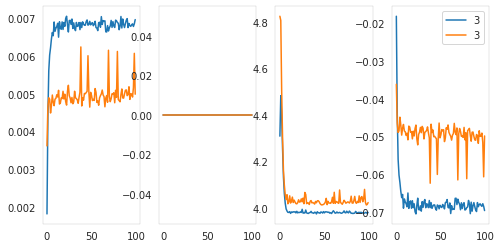

In [ ]:
fig, axs = plt.subplots(1, lossesTrain.shape[1],figsize=(8,4))
for i in range(lossesTrain.shape[1]):
  axs[i].plot(lossesTrain[:,i],label=str(i))
  axs[i].plot(lossesTest[:,i],label=str(i))

plt.legend()
plt.show()

NCA MCML Below

In [ ]:
# NCA loss only
acc_scoreNCA = []
acc_scoreNCA2 = []
acc_scoreNCA3 = []

for i in range(1): #3
  nca = MCML(n_latent = n_latent, epochs = 100)
  ncaR2 = MCML(n_latent = n_latent, epochs = 100)

  labels = np.array([lab1]).copy()
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  #2 labels
  labels2 = allLabs2.copy()
  labels2[:, unlab_inds] = np.nan


  losses, latent = nca.fit(scaled_mat,labels,fracNCA = 1, silent = True,ret_loss = True)

  losses2, latent2 = ncaR2.fit(scaled_mat,labels2,fracNCA = 1, silent = True,ret_loss = True)

  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latent, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds)
  acc_scoreNCA.append(acc)

  preds2 = knn_infer(latent2, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds2)
  acc_scoreNCA2.append(acc2)

  preds2 = knn_infer(latent2, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scoreNCA3.append(acc2)
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")


In [ ]:
print(acc_scoreNCA)
print(acc_scoreNCA2)
print(acc_scoreNCA3)

[0.6588744588744588]
[0.6493506493506493]
[0.8909090909090909]


In [ ]:
# fracNCA = 0.5
acc_scoreBoth = []
acc_scoreBoth2 = []
acc_scoreBoth3 = []

for i in range(3): #3
  nca = MCML(n_latent = n_latent, epochs = 100)
  ncaR2 = MCML(n_latent = n_latent, epochs = 100)

  labels = np.array([lab1]).copy()
  train_inds = np.random.choice(len(scaled_mat), size = int(0.7*len(scaled_mat)),replace=False) #0.7
  unlab_inds = [i for i in range(len(adata)) if i not in train_inds]
  labels[:, unlab_inds] = np.nan

  #2 labels
  labels2 = allLabs2.copy()
  labels2[:, unlab_inds] = np.nan

  losses, latent = nca.fit(scaled_mat,labels,fracNCA = 0.3, silent = True,ret_loss = True)

  losses2, latent2 = ncaR2.fit(scaled_mat,labels2,fracNCA = 0.3, silent = True,ret_loss = True)

  toc = time.perf_counter()
  unlabeled_idx = []
  for i in range(len(adata)):
      if i not in train_inds:
          unlabeled_idx.append(i)
  preds = knn_infer(latent, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds)
  acc_scoreBoth.append(acc)


  preds2 = knn_infer(latent2, train_inds, adata.obs.smartseq_cluster.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.smartseq_cluster.values[unlabeled_idx], preds2)
  acc_scoreBoth2.append(acc2)

  preds2 = knn_infer(latent2, train_inds, adata.obs.sex_label.values[train_inds], unlabeled_idx)
  acc2 = accuracy_score(adata.obs.sex_label.values[unlabeled_idx], preds2)
  acc_scoreBoth3.append(acc2)
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

In [ ]:
print(acc_scoreBoth)
print(acc_scoreBoth2)
print(acc_scoreBoth3)

[0.8649350649350649, 0.8666666666666667, 0.8926406926406927]
[0.8701298701298701, 0.8735930735930736, 0.8987012987012987]
[0.90995670995671, 0.9047619047619048, 0.8926406926406927]


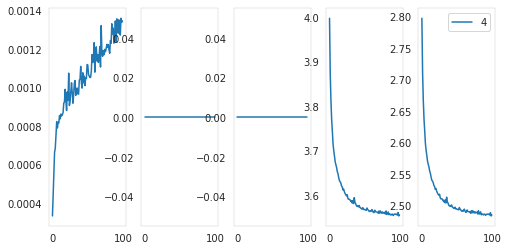

In [ ]:
fig, axs = plt.subplots(1, losses2.shape[1],figsize=(8,4))
for i in range(losses2.shape[1]):
  axs[i].plot(losses2[:,i],label=str(i))

plt.legend()
plt.show()

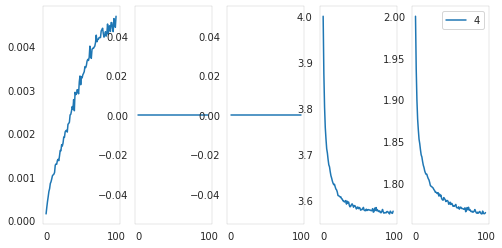

In [ ]:
fig, axs = plt.subplots(1, losses.shape[1],figsize=(8,4))
for i in range(losses.shape[1]):
  axs[i].plot(losses[:,i],label=str(i))

plt.legend()
plt.show()

In [ ]:
losses2

array([[0.        , 0.        , 0.        , 4.0293509 , 0.        ],
       [0.        , 0.        , 0.        , 3.98338677, 0.        ],
       [0.        , 0.        , 0.        , 3.97721616, 0.        ],
       ...,
       [0.        , 0.        , 0.        , 3.9778574 , 0.        ],
       [0.        , 0.        , 0.        , 3.97494724, 0.        ],
       [0.        , 0.        , 0.        , 3.97700665, 0.        ]])

### **Save Analysis Output**

In [ ]:
vals = pd.DataFrame()

vals['Accuracy'] = acc_score + acc_score_scanvi + acc_scoreR + acc_scoreNCA + acc_scoreBoth + acc_score2 + acc_score_scanvi2 + acc_scoreR2 + acc_scoreNCA3 + acc_scoreBoth3 + acc_scoreNCA2 + acc_scoreBoth2 +acc_scorePCA + acc_scorePCA2 + acc_score_2D + acc_scorePCA100D +acc_score_40_2D +acc_scorePCA40D #+ netAE_score + netAE_score2

In [ ]:
vals['Embed'] = ['LDVAE']*3 + ['SCANVI']*3 + ['Recon MCML']*3 + ['NCA 100% MCML']*1 + ['NCA-Recon MCML']*3 +['LDVAE']*3 + ['SCANVI']*3 + ['Recon MCML']*3 + ['NCA 100% MCML']*1 + ['NCA-Recon MCML']*3 + ['NCA 100% MCML']*1 + ['NCA-Recon MCML']*3 + ['PCA 50D']*3 +  ['PCA 50D']*3 + ['PCA 50D UMAP Sup.','PCA 50D UMAP','PCA 50D t-SNE']*3 + ['PCA 100D']*3 +['PCA 40D UMAP Sup.','PCA 40D UMAP','PCA 40D t-SNE']*3 + ['PCA 40D']*3#+ ['netAE']*2

In [ ]:
vals['Label'] = ['CellType1']*13 + ['Gender2']*13 + ['CellType2']*4 +['CellType1']*3 + ['Gender2']*3 + ['CellType1']*12+['CellType1']*12 #+  ['CellType1'] #+  ['Gender2']

In [ ]:
vals


,Accuracy,Embed,Label
0,0.828571,LDVAE,CellType1
1,0.849351,LDVAE,CellType1
2,0.863203,LDVAE,CellType1
3,0.867532,SCANVI,CellType1
4,0.875325,SCANVI,CellType1
5,0.870130,SCANVI,CellType1
6,0.884848,Recon MCML,CellType1
7,0.877922,Recon MCML,CellType1
8,0.880519,Recon MCML,CellType1
9,0.658874,NCA 100% MCML,CellType1


In [ ]:
from google.colab import files

vals.to_csv('allSmartSeqPreds_22.csv')
files.download('allSmartSeqPreds_22.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.9201716738197425